In [1]:
import torch
import tensorflow
from tensorflow.python.client import device_lib
def print_info():
    print('  Versión de TensorFlow: {}'.format(tensorflow.__version__))
    print('  GPU: {}'.format([x.physical_device_desc for x in device_lib.list_local_devices() if x.device_type == 'GPU']))
    print('  Versión Cuda  -> {}'.format(tensorflow.sysconfig.get_build_info()['cuda_version']))
    print('  Versión Cudnn -> {}\n'.format(tensorflow.sysconfig.get_build_info()['cudnn_version']))

print_info()

  Versión de TensorFlow: 2.9.0
  GPU: ['device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5']
  Versión Cuda  -> 64_112
  Versión Cudnn -> 64_8



In [2]:
#Import from library
from datetime import date, time, datetime
import numpy as np
import cv2
from skimage.measure import label, regionprops, regionprops_table
from os import makedirs
#Importar librerias
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Dropout
from keras.layers import LeakyReLU
#from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
# example of loading the mnist dataset
from keras.datasets.mnist import load_data
# load saved models
from keras.models import load_model

In [3]:
## Creacion de Dataset
data_img=[]
for num in range(1,5201):
    num_img = str(num).rjust(5,'0')
    dir_img = 'Imagenes\data_all\{}.png'.format(num_img)
    temp_img= cv2.imread(dir_img, cv2.IMREAD_GRAYSCALE)
    #th, im_th = cv2.threshold(temp_img, 128, 255, cv2.THRESH_BINARY)
    #plt.imshow(temp_img)
    resize = cv2.resize(temp_img,(56,56),interpolation = cv2.INTER_CUBIC)
    data_img.append(resize)
data_img = np.asarray(data_img)
data_img = data_img / 255.0
data_img = data_img.reshape(5200,56,56,1)

(5200, 56, 56, 1)


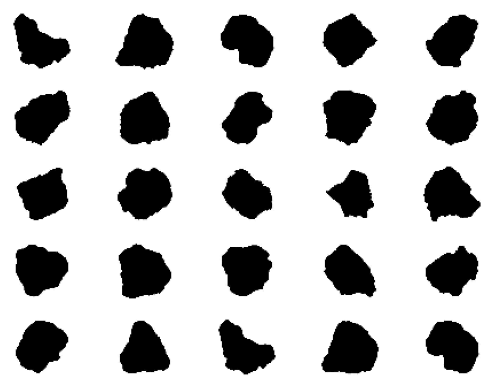

In [4]:
# plot images from the training dataset
for i in range(25):
    # define subplot
    plt.subplot(5, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(data_img[i], cmap='gray_r')
#filename = 'base_plot_2DGAN{}.png'.format(str(date.today()))
#plt.savefig(filename)
#plt.close()
#summarize the shape of the dataset
print(data_img.shape)


In [5]:

# define the standalone dicriminator model
def define_discriminator(in_shape=(56,56,1)):
    model = Sequential()
    model.add(Conv2D(64,
                     (3,3),
                     strides=(2,2),
                     padding='same',
                     input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64,
                     (3,3),
                     strides=(2,2),
                     padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(128,
                     (3,3),
                     strides=(2,2),
                     padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1,
                    activation='sigmoid'))
    model.summary()
    #compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [6]:

#define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    #foundation for 7x7 image
    n_nodes =256 *7*7 #features maps*dimensions
    model.add(Dense(n_nodes,
                    input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 256)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128,
                              (3,3),
                              strides=(2,2),
                              padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128,
                              (3,3),
                              strides=(2,2),
                              padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 56x56
    model.add(Conv2DTranspose(64,
                              (3,3),
                              strides=(2,2),
                              padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1,
                     (7,7),
                     activation='sigmoid',
                     padding='same'))
    model.summary()
    return model


In [7]:

#define the combined generator and dicriminatro model,
#for updating the generator
def define_gan(g_model,d_model):
    #make weights in the discriminator not trainable
    d_model.trainable = False
    #connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    #add the discriminator
    model.add(d_model)
    model.summary()
    #compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [8]:

## load and prepare mnist training images
def load_real_samples():
    # load mnist dataset
    (trainX, _), (_, _) = data_img
    #(trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels dimension
    X = expand_dims(trainX, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    #X = (X-127.5) / 127.5
    return X


In [9]:

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate ✬real✬ class labels (1)
    y = ones((n_samples, 1))
    return X, y


In [10]:

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


In [11]:

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create ✬fake✬ class labels (0)
    y = zeros((n_samples, 1))
    return X, y

In [12]:

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n,n, 1+i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0],
                   cmap='gray_r')
     # save plot to file
    filename = 'results/GAN_Ae/generated_2GAN_plot_e%04d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()


In [13]:

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, latent_dim, n_samples=100):
   
    x_fake, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    #filename = 'results/GAN_Ae/models/generator_2D_model_%03d.h5' % (epoch + 1)
    #g_model.save(filename)



In [14]:
# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist, a_hist):
    # plot loss
    #plt.subplot(2, 1, 1)
    plt.plot(d_hist, label='dis')
    plt.plot(g_hist, label='gen')
    plt.legend()
    # plot discriminator accuracy
    #plt.subplot(2, 1, 2)
    #plt.plot(a_hist, label='acc')
    #plt.legend()
    # save plot to file
    plt.savefig('results/GAN_Ae/eval/plot_line_plot_loss.png')
    plt.close()

In [15]:

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim,
          n_epochs=150, n_batch=128):
    # calculate the number of batches per epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)
    # calculate the total iterations based on batch and epoch
    n_steps = bat_per_epo * n_epochs
    # calculate the number of samples in half a batch
    half_batch = int(n_batch / 2)
    
    # prepare lists for storing stats each iteration
    d_hist, g_hist, a_hist = list(), list(), list()

# manually enumerate epochs
    for i in range(n_steps):
        # Train the discriminator 
        ## get randomly selected real samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # generate fake examples
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        ## combine into one batch
        X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
        # update discriminator model weights
        d_loss, d_acc = d_model.train_on_batch(X, y)
            
        #Train the generator
        # prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator✬s error
        g_loss, _ = gan_model.train_on_batch(X_gan, y_gan)
           
        # summarize loss on this batch
        print('>%d, d=%.3f, g=%.3f, a=%d' % (i+1, d_loss, g_loss, int(100*d_acc)))
        # record history
        d_hist.append(d_loss)
        g_hist.append(g_loss)
        a_hist.append(d_acc)
        # evaluate the model performance every epoch
        if (i+1) % bat_per_epo == 0:
            summarize_performance(i, g_model, latent_dim)
            #epoch, g_model, d_model, dataset, latent_dim,
    plot_history(d_hist, g_hist, a_hist)

In [16]:
#Make folder in dir
makedirs('results/GAN_Ae', exist_ok=True)
makedirs('results/GAN_Ae/models', exist_ok=True)
makedirs('results/GAN_Ae/eval', exist_ok=True)
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = data_img
#dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)#,n_epochs=20)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 64)        0         
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         7

2/2 [==============================] - 0s 0s/step
>42, d=0.255, g=4.813, a=93
2/2 [==============================] - 0s 16ms/step
>43, d=0.010, g=5.772, a=100
2/2 [==============================] - 0s 16ms/step
>44, d=0.002, g=6.312, a=100
2/2 [==============================] - 0s 6ms/step
>45, d=0.002, g=6.663, a=100
2/2 [==============================] - 0s 16ms/step
>46, d=0.001, g=6.772, a=100
2/2 [==============================] - 0s 16ms/step
>47, d=0.016, g=5.999, a=99
2/2 [==============================] - 0s 16ms/step
>48, d=0.005, g=5.625, a=100
2/2 [==============================] - 0s 0s/step
>49, d=0.012, g=5.837, a=99
2/2 [==============================] - 0s 0s/step
>50, d=0.012, g=6.463, a=99
2/2 [==============================] - 0s 0s/step
>51, d=0.003, g=6.635, a=100
2/2 [==============================] - 0s 9ms/step
>52, d=0.008, g=7.182, a=100
2/2 [==============================] - 0s 8ms/step
>53, d=0.001, g=7.278, a=100
2/2 [==============================] - 0s 9

2/2 [==============================] - 0s 16ms/step
>139, d=0.453, g=1.677, a=75
2/2 [==============================] - 0s 0s/step
>140, d=0.358, g=2.503, a=84
2/2 [==============================] - 0s 0s/step
>141, d=0.420, g=1.302, a=78
2/2 [==============================] - 0s 0s/step
>142, d=0.415, g=2.452, a=78
2/2 [==============================] - 0s 0s/step
>143, d=0.457, g=1.592, a=81
2/2 [==============================] - 0s 16ms/step
>144, d=0.474, g=1.967, a=74
2/2 [==============================] - 0s 0s/step
>145, d=0.387, g=1.812, a=87
2/2 [==============================] - 0s 6ms/step
>146, d=0.391, g=1.338, a=86
2/2 [==============================] - 0s 16ms/step
>147, d=0.456, g=2.240, a=75
2/2 [==============================] - 0s 16ms/step
>148, d=0.393, g=1.457, a=84
2/2 [==============================] - 0s 16ms/step
>149, d=0.389, g=1.481, a=82
2/2 [==============================] - 0s 16ms/step
>150, d=0.463, g=1.989, a=75
2/2 [==============================] - 

2/2 [==============================] - 0s 16ms/step
>235, d=0.576, g=0.925, a=72
2/2 [==============================] - 0s 16ms/step
>236, d=0.582, g=0.877, a=69
2/2 [==============================] - 0s 0s/step
>237, d=0.588, g=0.813, a=71
2/2 [==============================] - 0s 11ms/step
>238, d=0.661, g=0.957, a=57
2/2 [==============================] - 0s 9ms/step
>239, d=0.566, g=0.904, a=71
2/2 [==============================] - 0s 0s/step
>240, d=0.651, g=0.876, a=63
2/2 [==============================] - 0s 0s/step
>241, d=0.664, g=1.004, a=60
2/2 [==============================] - 0s 0s/step
>242, d=0.666, g=0.747, a=60
2/2 [==============================] - 0s 0s/step
>243, d=0.671, g=0.798, a=64
2/2 [==============================] - 0s 9ms/step
>244, d=0.661, g=0.986, a=60
2/2 [==============================] - 0s 0s/step
>245, d=0.660, g=0.937, a=61
2/2 [==============================] - 0s 16ms/step
>246, d=0.680, g=0.808, a=58
2/2 [==============================] - 0s 

2/2 [==============================] - 0s 0s/step
>329, d=0.671, g=0.794, a=57
2/2 [==============================] - 0s 16ms/step
>330, d=0.680, g=0.822, a=56
2/2 [==============================] - 0s 9ms/step
>331, d=0.659, g=0.772, a=61
2/2 [==============================] - 0s 23ms/step
>332, d=0.634, g=0.740, a=69
2/2 [==============================] - 0s 10ms/step
>333, d=0.710, g=0.771, a=52
2/2 [==============================] - 0s 7ms/step
>334, d=0.653, g=0.771, a=59
2/2 [==============================] - 0s 16ms/step
>335, d=0.671, g=0.796, a=57
2/2 [==============================] - 0s 8ms/step
>336, d=0.662, g=0.780, a=57
2/2 [==============================] - 0s 0s/step
>337, d=0.655, g=0.723, a=67
2/2 [==============================] - 0s 7ms/step
>338, d=0.618, g=0.790, a=71
2/2 [==============================] - 0s 16ms/step
>339, d=0.655, g=0.800, a=64
2/2 [==============================] - 0s 16ms/step
>340, d=0.692, g=0.778, a=49
2/2 [==============================]

2/2 [==============================] - 0s 16ms/step
>426, d=0.655, g=0.804, a=60
2/2 [==============================] - 0s 16ms/step
>427, d=0.643, g=0.767, a=62
2/2 [==============================] - 0s 16ms/step
>428, d=0.680, g=0.705, a=57
2/2 [==============================] - 0s 16ms/step
>429, d=0.683, g=0.972, a=54
2/2 [==============================] - 0s 16ms/step
>430, d=0.681, g=0.937, a=57
2/2 [==============================] - 0s 8ms/step
>431, d=0.718, g=0.702, a=50
2/2 [==============================] - 0s 0s/step
>432, d=0.665, g=0.698, a=56
2/2 [==============================] - 0s 16ms/step
>433, d=0.708, g=0.798, a=53
2/2 [==============================] - 0s 16ms/step
>434, d=0.649, g=0.755, a=65
2/2 [==============================] - 0s 0s/step
>435, d=0.636, g=0.713, a=67
2/2 [==============================] - 0s 0s/step
>436, d=0.672, g=0.678, a=57
2/2 [==============================] - 0s 0s/step
>437, d=0.648, g=0.748, a=62
2/2 [==============================] 

2/2 [==============================] - 0s 16ms/step
>521, d=0.722, g=0.742, a=44
2/2 [==============================] - 0s 16ms/step
>522, d=0.684, g=0.741, a=57
2/2 [==============================] - 0s 0s/step
>523, d=0.696, g=0.742, a=50
2/2 [==============================] - 0s 16ms/step
>524, d=0.698, g=0.711, a=48
2/2 [==============================] - 0s 16ms/step
>525, d=0.700, g=0.714, a=50
2/2 [==============================] - 0s 16ms/step
>526, d=0.711, g=0.693, a=48
2/2 [==============================] - 0s 0s/step
>527, d=0.710, g=0.703, a=41
2/2 [==============================] - 0s 0s/step
>528, d=0.679, g=0.712, a=57
2/2 [==============================] - 0s 0s/step
>529, d=0.681, g=0.741, a=51
2/2 [==============================] - 0s 16ms/step
>530, d=0.696, g=0.778, a=50
2/2 [==============================] - 0s 0s/step
>531, d=0.692, g=0.747, a=53
2/2 [==============================] - 0s 0s/step
>532, d=0.704, g=0.734, a=46
2/2 [==============================] - 0

>617, d=0.691, g=0.703, a=53
2/2 [==============================] - 0s 0s/step
>618, d=0.670, g=0.688, a=57
2/2 [==============================] - 0s 7ms/step
>619, d=0.682, g=0.725, a=57
2/2 [==============================] - 0s 9ms/step
>620, d=0.682, g=0.745, a=53
2/2 [==============================] - 0s 11ms/step
>621, d=0.678, g=0.712, a=50
2/2 [==============================] - 0s 10ms/step
>622, d=0.690, g=0.712, a=52
2/2 [==============================] - 0s 8ms/step
>623, d=0.679, g=0.683, a=51
2/2 [==============================] - 0s 12ms/step
>624, d=0.672, g=0.712, a=59
2/2 [==============================] - 0s 16ms/step
>625, d=0.709, g=0.689, a=53
2/2 [==============================] - 0s 6ms/step
>626, d=0.682, g=0.737, a=51
2/2 [==============================] - 0s 7ms/step
>627, d=0.689, g=0.753, a=60
2/2 [==============================] - 0s 9ms/step
>628, d=0.667, g=0.754, a=53
2/2 [==============================] - 0s 8ms/step
>629, d=0.708, g=0.735, a=46
2/2 [===

2/2 [==============================] - 0s 16ms/step
>714, d=0.687, g=0.702, a=55
2/2 [==============================] - 0s 0s/step
>715, d=0.708, g=0.727, a=47
2/2 [==============================] - 0s 9ms/step
>716, d=0.686, g=0.704, a=53
2/2 [==============================] - 0s 9ms/step
>717, d=0.697, g=0.714, a=50
2/2 [==============================] - 0s 9ms/step
>718, d=0.688, g=0.711, a=50
2/2 [==============================] - 0s 0s/step
>719, d=0.683, g=0.716, a=51
2/2 [==============================] - 0s 16ms/step
>720, d=0.702, g=0.729, a=51
2/2 [==============================] - 0s 0s/step
>721, d=0.665, g=0.725, a=66
2/2 [==============================] - 0s 0s/step
>722, d=0.677, g=0.736, a=53
2/2 [==============================] - 0s 16ms/step
>723, d=0.671, g=0.754, a=61
2/2 [==============================] - 0s 16ms/step
>724, d=0.689, g=0.733, a=57
2/2 [==============================] - 0s 16ms/step
>725, d=0.666, g=0.713, a=67
2/2 [==============================] - 

2/2 [==============================] - 0s 16ms/step
>808, d=0.702, g=0.755, a=50
2/2 [==============================] - 0s 16ms/step
>809, d=0.691, g=0.761, a=56
2/2 [==============================] - 0s 0s/step
>810, d=0.670, g=0.770, a=60
2/2 [==============================] - 0s 0s/step
>811, d=0.684, g=0.740, a=57
2/2 [==============================] - 0s 16ms/step
>812, d=0.686, g=0.724, a=49
2/2 [==============================] - 0s 0s/step
>813, d=0.693, g=0.761, a=53
2/2 [==============================] - 0s 0s/step
>814, d=0.699, g=0.789, a=47
2/2 [==============================] - 0s 0s/step
>815, d=0.686, g=0.749, a=52
2/2 [==============================] - 0s 0s/step
>816, d=0.679, g=0.733, a=53
2/2 [==============================] - 0s 0s/step
>817, d=0.695, g=0.716, a=47
2/2 [==============================] - 0s 16ms/step
>818, d=0.688, g=0.710, a=54
2/2 [==============================] - 0s 16ms/step
>819, d=0.694, g=0.740, a=55
2/2 [==============================] - 0s 

>904, d=0.697, g=0.707, a=53
2/2 [==============================] - 0s 16ms/step
>905, d=0.698, g=0.720, a=50
2/2 [==============================] - 0s 8ms/step
>906, d=0.718, g=0.716, a=40
2/2 [==============================] - 0s 9ms/step
>907, d=0.679, g=0.731, a=55
2/2 [==============================] - 0s 8ms/step
>908, d=0.699, g=0.723, a=49
2/2 [==============================] - 0s 9ms/step
>909, d=0.710, g=0.724, a=52
2/2 [==============================] - 0s 9ms/step
>910, d=0.670, g=0.737, a=57
2/2 [==============================] - 0s 13ms/step
>911, d=0.668, g=0.709, a=60
2/2 [==============================] - 0s 13ms/step
>912, d=0.677, g=0.717, a=55
2/2 [==============================] - 0s 13ms/step
>913, d=0.691, g=0.722, a=54
2/2 [==============================] - 0s 20ms/step
>914, d=0.691, g=0.724, a=56
2/2 [==============================] - 0s 14ms/step
>915, d=0.704, g=0.703, a=46
2/2 [==============================] - 0s 15ms/step
>916, d=0.692, g=0.697, a=53
2/2 

2/2 [==============================] - 0s 0s/step
>1001, d=0.671, g=0.718, a=60
2/2 [==============================] - 0s 16ms/step
>1002, d=0.689, g=0.735, a=52
2/2 [==============================] - 0s 16ms/step
>1003, d=0.662, g=0.735, a=61
2/2 [==============================] - 0s 16ms/step
>1004, d=0.672, g=0.710, a=58
2/2 [==============================] - 0s 0s/step
>1005, d=0.683, g=0.717, a=56
2/2 [==============================] - 0s 0s/step
>1006, d=0.687, g=0.726, a=58
2/2 [==============================] - 0s 0s/step
>1007, d=0.675, g=0.709, a=59
2/2 [==============================] - 0s 0s/step
>1008, d=0.683, g=0.733, a=59
2/2 [==============================] - 0s 13ms/step
>1009, d=0.672, g=0.715, a=57
2/2 [==============================] - 0s 16ms/step
>1010, d=0.663, g=0.720, a=60
2/2 [==============================] - 0s 16ms/step
>1011, d=0.674, g=0.726, a=55
2/2 [==============================] - 0s 0s/step
>1012, d=0.709, g=0.732, a=50
2/2 [=======================

>1093, d=0.671, g=0.711, a=58
2/2 [==============================] - 0s 0s/step
>1094, d=0.679, g=0.705, a=58
2/2 [==============================] - 0s 0s/step
>1095, d=0.698, g=0.717, a=55
2/2 [==============================] - 0s 16ms/step
>1096, d=0.691, g=0.714, a=50
2/2 [==============================] - 0s 16ms/step
>1097, d=0.697, g=0.713, a=49
2/2 [==============================] - 0s 16ms/step
>1098, d=0.704, g=0.700, a=47
2/2 [==============================] - 0s 0s/step
>1099, d=0.685, g=0.700, a=53
2/2 [==============================] - 0s 16ms/step
>1100, d=0.674, g=0.727, a=55
2/2 [==============================] - 0s 16ms/step
>1101, d=0.687, g=0.724, a=60
2/2 [==============================] - 0s 16ms/step
>1102, d=0.674, g=0.727, a=62
2/2 [==============================] - 0s 16ms/step
>1103, d=0.687, g=0.751, a=50
2/2 [==============================] - 0s 16ms/step
>1104, d=0.680, g=0.741, a=57
2/2 [==============================] - 0s 16ms/step
>1105, d=0.692, g=0.73

2/2 [==============================] - 0s 16ms/step
>1189, d=0.695, g=0.705, a=53
2/2 [==============================] - 0s 16ms/step
>1190, d=0.671, g=0.695, a=60
2/2 [==============================] - 0s 0s/step
>1191, d=0.660, g=0.711, a=61
2/2 [==============================] - 0s 0s/step
>1192, d=0.706, g=0.725, a=50
2/2 [==============================] - 0s 0s/step
>1193, d=0.689, g=0.708, a=50
2/2 [==============================] - 0s 0s/step
>1194, d=0.685, g=0.700, a=54
2/2 [==============================] - 0s 16ms/step
>1195, d=0.677, g=0.697, a=60
2/2 [==============================] - 0s 16ms/step
>1196, d=0.685, g=0.715, a=53
2/2 [==============================] - 0s 16ms/step
>1197, d=0.704, g=0.764, a=50
2/2 [==============================] - 0s 16ms/step
>1198, d=0.684, g=0.726, a=60
2/2 [==============================] - 0s 0s/step
>1199, d=0.700, g=0.727, a=48
2/2 [==============================] - 0s 16ms/step
>1200, d=0.679, g=0.718, a=55
2/2 [=====================

>1281, d=0.695, g=0.719, a=49
2/2 [==============================] - 0s 10ms/step
>1282, d=0.667, g=0.749, a=64
2/2 [==============================] - 0s 15ms/step
>1283, d=0.680, g=0.738, a=58
2/2 [==============================] - 0s 9ms/step
>1284, d=0.678, g=0.752, a=55
2/2 [==============================] - 0s 16ms/step
>1285, d=0.701, g=0.728, a=50
2/2 [==============================] - 0s 16ms/step
>1286, d=0.673, g=0.702, a=57
2/2 [==============================] - 0s 16ms/step
>1287, d=0.672, g=0.691, a=63
2/2 [==============================] - 0s 16ms/step
>1288, d=0.690, g=0.725, a=55
2/2 [==============================] - 0s 16ms/step
>1289, d=0.711, g=0.722, a=46
2/2 [==============================] - 0s 16ms/step
>1290, d=0.676, g=0.729, a=61
2/2 [==============================] - 0s 0s/step
>1291, d=0.673, g=0.711, a=61
2/2 [==============================] - 0s 16ms/step
>1292, d=0.673, g=0.707, a=59
2/2 [==============================] - 0s 16ms/step
>1293, d=0.683, g=0

2/2 [==============================] - 0s 0s/step
>1377, d=0.669, g=0.707, a=57
2/2 [==============================] - 0s 0s/step
>1378, d=0.676, g=0.730, a=57
2/2 [==============================] - 0s 9ms/step
>1379, d=0.681, g=0.749, a=54
2/2 [==============================] - 0s 0s/step
>1380, d=0.655, g=0.736, a=65
2/2 [==============================] - 0s 16ms/step
>1381, d=0.677, g=0.757, a=60
2/2 [==============================] - 0s 16ms/step
>1382, d=0.680, g=0.735, a=47
2/2 [==============================] - 0s 0s/step
>1383, d=0.690, g=0.759, a=54
2/2 [==============================] - 0s 16ms/step
>1384, d=0.677, g=0.724, a=57
2/2 [==============================] - 0s 20ms/step
>1385, d=0.665, g=0.718, a=60
2/2 [==============================] - 0s 0s/step
>1386, d=0.674, g=0.699, a=59
2/2 [==============================] - 0s 15ms/step
>1387, d=0.688, g=0.734, a=58
2/2 [==============================] - 0s 15ms/step
>1388, d=0.674, g=0.737, a=60
2/2 [======================

2/2 [==============================] - 0s 16ms/step
>1472, d=0.656, g=0.767, a=61
2/2 [==============================] - 0s 16ms/step
>1473, d=0.663, g=0.714, a=63
2/2 [==============================] - 0s 16ms/step
>1474, d=0.690, g=0.722, a=57
2/2 [==============================] - 0s 16ms/step
>1475, d=0.688, g=0.717, a=48
2/2 [==============================] - 0s 16ms/step
>1476, d=0.683, g=0.711, a=57
2/2 [==============================] - 0s 20ms/step
>1477, d=0.672, g=0.707, a=59
2/2 [==============================] - 0s 0s/step
>1478, d=0.668, g=0.708, a=63
2/2 [==============================] - 0s 0s/step
>1479, d=0.681, g=0.726, a=54
2/2 [==============================] - 0s 0s/step
>1480, d=0.673, g=0.738, a=61
2/2 [==============================] - 0s 16ms/step
>1481, d=0.685, g=0.754, a=57
2/2 [==============================] - 0s 0s/step
>1482, d=0.691, g=0.735, a=54
2/2 [==============================] - 0s 13ms/step
>1483, d=0.678, g=0.740, a=57
2/2 [===================

>1564, d=0.680, g=0.745, a=59
2/2 [==============================] - 0s 0s/step
>1565, d=0.683, g=0.737, a=53
2/2 [==============================] - 0s 16ms/step
>1566, d=0.662, g=0.684, a=58
2/2 [==============================] - 0s 16ms/step
>1567, d=0.671, g=0.735, a=56
2/2 [==============================] - 0s 0s/step
>1568, d=0.687, g=0.751, a=50
2/2 [==============================] - 0s 0s/step
>1569, d=0.664, g=0.747, a=61
2/2 [==============================] - 0s 16ms/step
>1570, d=0.672, g=0.779, a=58
2/2 [==============================] - 0s 9ms/step
>1571, d=0.672, g=0.799, a=55
2/2 [==============================] - 0s 9ms/step
>1572, d=0.664, g=0.754, a=59
2/2 [==============================] - 0s 1ms/step
>1573, d=0.663, g=0.730, a=58
2/2 [==============================] - 0s 8ms/step
>1574, d=0.681, g=0.721, a=55
2/2 [==============================] - 0s 0s/step
>1575, d=0.681, g=0.737, a=51
2/2 [==============================] - 0s 0s/step
>1576, d=0.677, g=0.731, a=56


>1659, d=0.686, g=0.753, a=55
2/2 [==============================] - 0s 23ms/step
>1660, d=0.665, g=0.716, a=60
2/2 [==============================] - 0s 6ms/step
>1661, d=0.679, g=0.718, a=60
2/2 [==============================] - 0s 18ms/step
>1662, d=0.655, g=0.741, a=57
2/2 [==============================] - 0s 16ms/step
>1663, d=0.663, g=0.745, a=61
2/2 [==============================] - 0s 7ms/step
>1664, d=0.675, g=0.700, a=56
2/2 [==============================] - 0s 7ms/step
>1665, d=0.667, g=0.756, a=58
2/2 [==============================] - 0s 9ms/step
>1666, d=0.685, g=0.726, a=53
2/2 [==============================] - 0s 16ms/step
>1667, d=0.662, g=0.736, a=63
2/2 [==============================] - 0s 16ms/step
>1668, d=0.654, g=0.783, a=64
2/2 [==============================] - 0s 0s/step
>1669, d=0.651, g=0.834, a=67
2/2 [==============================] - 0s 999us/step
>1670, d=0.663, g=0.786, a=57
2/2 [==============================] - 0s 9ms/step
>1671, d=0.669, g=0.73

2/2 [==============================] - 0s 16ms/step
>1755, d=0.664, g=0.824, a=60
2/2 [==============================] - 0s 16ms/step
>1756, d=0.653, g=0.786, a=60
2/2 [==============================] - 0s 0s/step
>1757, d=0.655, g=0.740, a=62
2/2 [==============================] - 0s 16ms/step
>1758, d=0.657, g=0.812, a=61
2/2 [==============================] - 0s 0s/step
>1759, d=0.657, g=0.752, a=63
2/2 [==============================] - 0s 0s/step
>1760, d=0.656, g=0.761, a=63
2/2 [==============================] - 0s 16ms/step
>1761, d=0.660, g=0.727, a=61
2/2 [==============================] - 0s 16ms/step
>1762, d=0.663, g=0.737, a=57
2/2 [==============================] - 0s 16ms/step
>1763, d=0.653, g=0.792, a=64
2/2 [==============================] - 0s 9ms/step
>1764, d=0.673, g=0.791, a=57
2/2 [==============================] - 0s 8ms/step
>1765, d=0.684, g=0.798, a=55
2/2 [==============================] - 0s 0s/step
>1766, d=0.647, g=0.785, a=64
2/2 [=====================

2/2 [==============================] - 0s 16ms/step
>1848, d=0.652, g=0.750, a=58
2/2 [==============================] - 0s 16ms/step
>1849, d=0.629, g=0.754, a=60
2/2 [==============================] - 0s 16ms/step
>1850, d=0.633, g=0.787, a=59
2/2 [==============================] - 0s 16ms/step
>1851, d=0.658, g=0.824, a=59
2/2 [==============================] - 0s 16ms/step
>1852, d=0.625, g=0.828, a=60
2/2 [==============================] - 0s 16ms/step
>1853, d=0.676, g=0.847, a=52
2/2 [==============================] - 0s 9ms/step
>1854, d=0.658, g=0.799, a=60
2/2 [==============================] - 0s 16ms/step
>1855, d=0.658, g=0.742, a=62
2/2 [==============================] - 0s 16ms/step
>1856, d=0.680, g=0.738, a=53
2/2 [==============================] - 0s 16ms/step
>1857, d=0.626, g=0.804, a=64
2/2 [==============================] - 0s 16ms/step
>1858, d=0.627, g=0.767, a=64
2/2 [==============================] - 0s 16ms/step
>1859, d=0.634, g=0.774, a=67
2/2 [============

2/2 [==============================] - 0s 22ms/step
>1943, d=0.631, g=0.830, a=64
2/2 [==============================] - 0s 7ms/step
>1944, d=0.661, g=0.786, a=57
2/2 [==============================] - 0s 15ms/step
>1945, d=0.630, g=0.755, a=57
2/2 [==============================] - 0s 15ms/step
>1946, d=0.689, g=0.748, a=59
2/2 [==============================] - 0s 0s/step
>1947, d=0.663, g=0.810, a=59
2/2 [==============================] - 0s 0s/step
>1948, d=0.632, g=0.836, a=60
2/2 [==============================] - 0s 0s/step
>1949, d=0.663, g=0.801, a=58
2/2 [==============================] - 0s 16ms/step
>1950, d=0.667, g=0.838, a=57
2/2 [==============================] - 0s 15ms/step
>1951, d=0.638, g=0.818, a=63
2/2 [==============================] - 0s 8ms/step
>1952, d=0.673, g=0.785, a=58
2/2 [==============================] - 0s 9ms/step
>1953, d=0.611, g=0.785, a=64
2/2 [==============================] - 0s 15ms/step
>1954, d=0.607, g=0.757, a=71
2/2 [====================

2/2 [==============================] - 0s 16ms/step
>2038, d=0.633, g=0.852, a=65
2/2 [==============================] - 0s 16ms/step
>2039, d=0.669, g=0.796, a=59
2/2 [==============================] - 0s 0s/step
>2040, d=0.639, g=0.894, a=62
2/2 [==============================] - 0s 16ms/step
>2041, d=0.642, g=0.941, a=64
2/2 [==============================] - 0s 16ms/step
>2042, d=0.655, g=0.846, a=61
2/2 [==============================] - 0s 0s/step
>2043, d=0.649, g=0.936, a=57
2/2 [==============================] - 0s 0s/step
>2044, d=0.643, g=0.751, a=64
2/2 [==============================] - 0s 0s/step
>2045, d=0.626, g=0.802, a=67
2/2 [==============================] - 0s 0s/step
>2046, d=0.637, g=0.810, a=61
2/2 [==============================] - 0s 9ms/step
>2047, d=0.613, g=0.842, a=64
2/2 [==============================] - 0s 16ms/step
>2048, d=0.644, g=0.853, a=65
2/2 [==============================] - 0s 16ms/step
>2049, d=0.658, g=0.873, a=57
2/2 [======================

>2130, d=0.653, g=0.800, a=62
2/2 [==============================] - 0s 10ms/step
>2131, d=0.610, g=0.753, a=63
2/2 [==============================] - 0s 16ms/step
>2132, d=0.660, g=0.779, a=59
2/2 [==============================] - 0s 0s/step
>2133, d=0.625, g=0.910, a=67
2/2 [==============================] - 0s 16ms/step
>2134, d=0.611, g=0.854, a=65
2/2 [==============================] - 0s 16ms/step
>2135, d=0.574, g=0.841, a=67
2/2 [==============================] - 0s 10ms/step
>2136, d=0.652, g=0.830, a=62
2/2 [==============================] - 0s 14ms/step
>2137, d=0.673, g=0.914, a=57
2/2 [==============================] - 0s 16ms/step
>2138, d=0.651, g=0.918, a=60
2/2 [==============================] - 0s 0s/step
>2139, d=0.609, g=0.913, a=61
2/2 [==============================] - 0s 999us/step
>2140, d=0.688, g=0.840, a=57
2/2 [==============================] - 0s 16ms/step
>2141, d=0.627, g=0.882, a=63
2/2 [==============================] - 0s 9ms/step
>2142, d=0.662, g=0.

2/2 [==============================] - 0s 0s/step
>2226, d=0.636, g=0.813, a=66
2/2 [==============================] - 0s 0s/step
>2227, d=0.644, g=0.774, a=65
2/2 [==============================] - 0s 16ms/step
>2228, d=0.653, g=0.845, a=57
2/2 [==============================] - 0s 16ms/step
>2229, d=0.652, g=0.830, a=63
2/2 [==============================] - 0s 16ms/step
>2230, d=0.634, g=0.900, a=61
2/2 [==============================] - 0s 8ms/step
>2231, d=0.611, g=0.903, a=64
2/2 [==============================] - 0s 0s/step
>2232, d=0.662, g=0.884, a=58
2/2 [==============================] - 0s 15ms/step
>2233, d=0.631, g=0.861, a=62
2/2 [==============================] - 0s 16ms/step
>2234, d=0.620, g=0.862, a=64
2/2 [==============================] - 0s 0s/step
>2235, d=0.603, g=0.924, a=72
2/2 [==============================] - 0s 0s/step
>2236, d=0.597, g=0.989, a=67
2/2 [==============================] - 0s 16ms/step
>2237, d=0.649, g=0.899, a=65
2/2 [======================

2/2 [==============================] - 0s 9ms/step
>2321, d=0.615, g=0.845, a=66
2/2 [==============================] - 0s 22ms/step
>2322, d=0.681, g=0.798, a=57
2/2 [==============================] - 0s 0s/step
>2323, d=0.638, g=0.911, a=59
2/2 [==============================] - 0s 4ms/step
>2324, d=0.631, g=0.879, a=60
2/2 [==============================] - 0s 9ms/step
>2325, d=0.614, g=0.900, a=68
2/2 [==============================] - 0s 9ms/step
>2326, d=0.607, g=0.920, a=65
2/2 [==============================] - 0s 9ms/step
>2327, d=0.659, g=0.881, a=65
2/2 [==============================] - 0s 16ms/step
>2328, d=0.632, g=0.863, a=61
2/2 [==============================] - 0s 9ms/step
>2329, d=0.614, g=0.846, a=67
2/2 [==============================] - 0s 14ms/step
>2330, d=0.665, g=0.806, a=60
2/2 [==============================] - 0s 15ms/step
>2331, d=0.631, g=0.838, a=68
2/2 [==============================] - 0s 9ms/step
>2332, d=0.606, g=0.841, a=63
2/2 [====================

2/2 [==============================] - 0s 16ms/step
>2414, d=0.631, g=0.891, a=60
2/2 [==============================] - 0s 16ms/step
>2415, d=0.638, g=0.870, a=59
2/2 [==============================] - 0s 7ms/step
>2416, d=0.643, g=0.815, a=59
2/2 [==============================] - 0s 0s/step
>2417, d=0.656, g=0.816, a=59
2/2 [==============================] - 0s 0s/step
>2418, d=0.641, g=0.872, a=61
2/2 [==============================] - 0s 5ms/step
>2419, d=0.620, g=0.909, a=67
2/2 [==============================] - 0s 9ms/step
>2420, d=0.593, g=0.886, a=73
2/2 [==============================] - 0s 9ms/step
>2421, d=0.596, g=0.908, a=71
2/2 [==============================] - 0s 0s/step
>2422, d=0.625, g=0.898, a=67
2/2 [==============================] - 0s 0s/step
>2423, d=0.653, g=0.803, a=63
2/2 [==============================] - 0s 16ms/step
>2424, d=0.650, g=0.739, a=57
2/2 [==============================] - 0s 16ms/step
>2425, d=0.623, g=0.826, a=60
2/2 [=======================

2/2 [==============================] - 0s 16ms/step
>2509, d=0.613, g=0.899, a=74
2/2 [==============================] - 0s 16ms/step
>2510, d=0.638, g=0.860, a=57
2/2 [==============================] - 0s 16ms/step
>2511, d=0.627, g=0.799, a=64
2/2 [==============================] - 0s 0s/step
>2512, d=0.659, g=0.822, a=59
2/2 [==============================] - 0s 0s/step
>2513, d=0.599, g=0.875, a=67
2/2 [==============================] - 0s 16ms/step
>2514, d=0.654, g=0.893, a=62
2/2 [==============================] - 0s 16ms/step
>2515, d=0.600, g=0.807, a=71
2/2 [==============================] - 0s 16ms/step
>2516, d=0.664, g=0.813, a=61
2/2 [==============================] - 0s 16ms/step
>2517, d=0.675, g=0.913, a=57
2/2 [==============================] - 0s 0s/step
>2518, d=0.630, g=0.886, a=64
2/2 [==============================] - 0s 0s/step
>2519, d=0.626, g=0.910, a=65
2/2 [==============================] - 0s 16ms/step
>2520, d=0.623, g=0.867, a=65
2/2 [===================

2/2 [==============================] - 0s 14ms/step
>2602, d=0.632, g=0.820, a=63
2/2 [==============================] - 0s 16ms/step
>2603, d=0.642, g=0.831, a=61
2/2 [==============================] - 0s 9ms/step
>2604, d=0.631, g=0.796, a=66
2/2 [==============================] - 0s 0s/step
>2605, d=0.619, g=0.881, a=65
2/2 [==============================] - 0s 11ms/step
>2606, d=0.613, g=0.815, a=65
2/2 [==============================] - 0s 16ms/step
>2607, d=0.641, g=0.904, a=62
2/2 [==============================] - 0s 0s/step
>2608, d=0.612, g=0.890, a=62
2/2 [==============================] - 0s 16ms/step
>2609, d=0.652, g=0.841, a=60
2/2 [==============================] - 0s 16ms/step
>2610, d=0.607, g=0.870, a=64
2/2 [==============================] - 0s 16ms/step
>2611, d=0.671, g=0.835, a=55
2/2 [==============================] - 0s 16ms/step
>2612, d=0.635, g=0.903, a=69
2/2 [==============================] - 0s 16ms/step
>2613, d=0.651, g=0.823, a=61
2/2 [================

2/2 [==============================] - 0s 9ms/step
>2697, d=0.584, g=0.862, a=71
2/2 [==============================] - 0s 18ms/step
>2698, d=0.633, g=0.875, a=65
2/2 [==============================] - 0s 19ms/step
>2699, d=0.645, g=0.895, a=60
2/2 [==============================] - 0s 7ms/step
>2700, d=0.632, g=0.842, a=64
2/2 [==============================] - 0s 8ms/step
>2701, d=0.621, g=0.780, a=64
2/2 [==============================] - 0s 9ms/step
>2702, d=0.652, g=0.767, a=64
2/2 [==============================] - 0s 22ms/step
>2703, d=0.575, g=0.816, a=69
2/2 [==============================] - 0s 10ms/step
>2704, d=0.653, g=0.884, a=66
2/2 [==============================] - 0s 12ms/step
>2705, d=0.619, g=0.912, a=68
2/2 [==============================] - 0s 0s/step
>2706, d=0.622, g=0.894, a=65
2/2 [==============================] - 0s 0s/step
>2707, d=0.627, g=0.890, a=64
2/2 [==============================] - 0s 16ms/step
>2708, d=0.626, g=0.886, a=68
2/2 [===================

2/2 [==============================] - 0s 14ms/step
>2792, d=0.624, g=0.867, a=67
2/2 [==============================] - 0s 9ms/step
>2793, d=0.629, g=0.857, a=66
2/2 [==============================] - 0s 8ms/step
>2794, d=0.616, g=0.874, a=64
2/2 [==============================] - 0s 14ms/step
>2795, d=0.654, g=0.885, a=60
2/2 [==============================] - 0s 9ms/step
>2796, d=0.678, g=0.882, a=53
2/2 [==============================] - 0s 6ms/step
>2797, d=0.612, g=0.916, a=65
2/2 [==============================] - 0s 7ms/step
>2798, d=0.625, g=0.883, a=67
2/2 [==============================] - 0s 8ms/step
>2799, d=0.613, g=0.881, a=64
2/2 [==============================] - 0s 19ms/step
>2800, d=0.564, g=0.925, a=71
2/2 [==============================] - 0s 29ms/step
>2801, d=0.620, g=0.858, a=63
2/2 [==============================] - 0s 14ms/step
>2802, d=0.666, g=0.893, a=60
2/2 [==============================] - 0s 9ms/step
>2803, d=0.617, g=0.884, a=67
2/2 [==================

2/2 [==============================] - 0s 14ms/step
>2884, d=0.599, g=0.992, a=65
2/2 [==============================] - 0s 9ms/step
>2885, d=0.618, g=0.856, a=66
2/2 [==============================] - 0s 7ms/step
>2886, d=0.583, g=0.766, a=66
2/2 [==============================] - 0s 13ms/step
>2887, d=0.644, g=0.804, a=65
2/2 [==============================] - 0s 9ms/step
>2888, d=0.644, g=0.894, a=62
2/2 [==============================] - 0s 10ms/step
>2889, d=0.653, g=0.890, a=62
2/2 [==============================] - 0s 14ms/step
>2890, d=0.669, g=0.923, a=60
2/2 [==============================] - 0s 19ms/step
>2891, d=0.659, g=0.897, a=61
2/2 [==============================] - 0s 22ms/step
>2892, d=0.615, g=0.885, a=67
2/2 [==============================] - 0s 9ms/step
>2893, d=0.630, g=0.848, a=63
2/2 [==============================] - 0s 10ms/step
>2894, d=0.614, g=0.878, a=64
2/2 [==============================] - 0s 11ms/step
>2895, d=0.616, g=0.953, a=65
2/2 [===============

2/2 [==============================] - 0s 10ms/step
>2979, d=0.635, g=0.942, a=64
2/2 [==============================] - 0s 9ms/step
>2980, d=0.634, g=0.813, a=65
2/2 [==============================] - 0s 14ms/step
>2981, d=0.619, g=0.792, a=59
2/2 [==============================] - 0s 6ms/step
>2982, d=0.617, g=0.863, a=65
2/2 [==============================] - 0s 19ms/step
>2983, d=0.640, g=0.904, a=63
2/2 [==============================] - 0s 19ms/step
>2984, d=0.582, g=0.846, a=68
2/2 [==============================] - 0s 19ms/step
>2985, d=0.617, g=0.844, a=65
2/2 [==============================] - 0s 16ms/step
>2986, d=0.638, g=0.889, a=63
2/2 [==============================] - 0s 6ms/step
>2987, d=0.604, g=0.930, a=63
2/2 [==============================] - 0s 7ms/step
>2988, d=0.619, g=0.950, a=67
2/2 [==============================] - 0s 12ms/step
>2989, d=0.618, g=0.797, a=67
2/2 [==============================] - 0s 14ms/step
>2990, d=0.611, g=0.824, a=63
2/2 [===============

2/2 [==============================] - 0s 16ms/step
>3074, d=0.632, g=0.902, a=67
2/2 [==============================] - 0s 16ms/step
>3075, d=0.618, g=0.894, a=64
2/2 [==============================] - 0s 16ms/step
>3076, d=0.635, g=0.827, a=62
2/2 [==============================] - 0s 0s/step
>3077, d=0.625, g=0.834, a=64
2/2 [==============================] - 0s 0s/step
>3078, d=0.626, g=0.901, a=63
2/2 [==============================] - 0s 0s/step
>3079, d=0.584, g=0.946, a=67
2/2 [==============================] - 0s 16ms/step
>3080, d=0.611, g=0.967, a=68
2/2 [==============================] - 0s 16ms/step
>3081, d=0.603, g=0.915, a=64
2/2 [==============================] - 0s 0s/step
>3082, d=0.599, g=0.928, a=71
2/2 [==============================] - 0s 0s/step
>3083, d=0.603, g=0.900, a=68
2/2 [==============================] - 0s 0s/step
>3084, d=0.602, g=0.927, a=67
2/2 [==============================] - 0s 16ms/step
>3085, d=0.564, g=0.888, a=72
2/2 [=======================

2/2 [==============================] - 0s 0s/step
>3166, d=0.620, g=0.939, a=64
2/2 [==============================] - 0s 0s/step
>3167, d=0.620, g=0.897, a=64
2/2 [==============================] - 0s 0s/step
>3168, d=0.660, g=0.866, a=55
2/2 [==============================] - 0s 0s/step
>3169, d=0.625, g=0.944, a=66
2/2 [==============================] - 0s 2ms/step
>3170, d=0.669, g=0.998, a=56
2/2 [==============================] - 0s 0s/step
>3171, d=0.631, g=0.856, a=64
2/2 [==============================] - 0s 0s/step
>3172, d=0.629, g=0.883, a=59
2/2 [==============================] - 0s 0s/step
>3173, d=0.602, g=0.831, a=67
2/2 [==============================] - 0s 0s/step
>3174, d=0.616, g=0.918, a=64
2/2 [==============================] - 0s 16ms/step
>3175, d=0.605, g=0.874, a=67
2/2 [==============================] - 0s 16ms/step
>3176, d=0.666, g=0.809, a=60
2/2 [==============================] - 0s 16ms/step
>3177, d=0.637, g=0.885, a=67
2/2 [============================

2/2 [==============================] - 0s 7ms/step
>3262, d=0.590, g=0.906, a=67
2/2 [==============================] - 0s 16ms/step
>3263, d=0.615, g=1.049, a=69
2/2 [==============================] - 0s 16ms/step
>3264, d=0.613, g=0.981, a=69
2/2 [==============================] - 0s 7ms/step
>3265, d=0.581, g=0.969, a=70
2/2 [==============================] - 0s 16ms/step
>3266, d=0.599, g=0.924, a=67
2/2 [==============================] - 0s 16ms/step
>3267, d=0.608, g=0.920, a=65
2/2 [==============================] - 0s 16ms/step
>3268, d=0.583, g=1.020, a=67
2/2 [==============================] - 0s 16ms/step
>3269, d=0.600, g=0.973, a=66
2/2 [==============================] - 0s 0s/step
>3270, d=0.625, g=0.853, a=61
2/2 [==============================] - 0s 5ms/step
>3271, d=0.647, g=0.852, a=59
2/2 [==============================] - 0s 16ms/step
>3272, d=0.626, g=0.947, a=70
2/2 [==============================] - 0s 7ms/step
>3273, d=0.566, g=0.952, a=70
2/2 [=================

2/2 [==============================] - 0s 16ms/step
>3357, d=0.575, g=1.033, a=75
2/2 [==============================] - 0s 0s/step
>3358, d=0.624, g=0.964, a=65
2/2 [==============================] - 0s 5ms/step
>3359, d=0.570, g=0.939, a=69
2/2 [==============================] - 0s 16ms/step
>3360, d=0.594, g=1.019, a=65
2/2 [==============================] - 0s 16ms/step
>3361, d=0.581, g=0.922, a=68
2/2 [==============================] - 0s 0s/step
>3362, d=0.558, g=0.984, a=71
2/2 [==============================] - 0s 16ms/step
>3363, d=0.571, g=0.932, a=68
2/2 [==============================] - 0s 19ms/step
>3364, d=0.564, g=1.068, a=72
2/2 [==============================] - 0s 15ms/step
>3365, d=0.596, g=1.033, a=68
2/2 [==============================] - 0s 4ms/step
>3366, d=0.668, g=1.122, a=64
2/2 [==============================] - 0s 16ms/step
>3367, d=0.572, g=1.129, a=63
2/2 [==============================] - 0s 16ms/step
>3368, d=0.607, g=1.055, a=66
2/2 [=================

2/2 [==============================] - 0s 7ms/step
>3450, d=0.603, g=1.038, a=67
2/2 [==============================] - 0s 7ms/step
>3451, d=0.586, g=1.017, a=71
2/2 [==============================] - 0s 9ms/step
>3452, d=0.563, g=0.935, a=68
2/2 [==============================] - 0s 17ms/step
>3453, d=0.598, g=0.962, a=67
2/2 [==============================] - 0s 7ms/step
>3454, d=0.629, g=1.092, a=62
2/2 [==============================] - 0s 15ms/step
>3455, d=0.589, g=0.958, a=71
2/2 [==============================] - 0s 9ms/step
>3456, d=0.569, g=0.911, a=71
2/2 [==============================] - 0s 16ms/step
>3457, d=0.598, g=0.943, a=67
2/2 [==============================] - 0s 13ms/step
>3458, d=0.523, g=0.947, a=71
2/2 [==============================] - 0s 10ms/step
>3459, d=0.596, g=1.006, a=62
2/2 [==============================] - 0s 8ms/step
>3460, d=0.604, g=1.039, a=67
2/2 [==============================] - 0s 10ms/step
>3461, d=0.606, g=1.047, a=71
2/2 [=================

2/2 [==============================] - 0s 16ms/step
>3545, d=0.547, g=0.920, a=71
2/2 [==============================] - 0s 16ms/step
>3546, d=0.541, g=0.893, a=71
2/2 [==============================] - 0s 16ms/step
>3547, d=0.536, g=1.043, a=78
2/2 [==============================] - 0s 0s/step
>3548, d=0.519, g=1.123, a=75
2/2 [==============================] - 0s 0s/step
>3549, d=0.546, g=1.124, a=71
2/2 [==============================] - 0s 16ms/step
>3550, d=0.511, g=1.198, a=74
2/2 [==============================] - 0s 16ms/step
>3551, d=0.630, g=1.188, a=65
2/2 [==============================] - 0s 16ms/step
>3552, d=0.594, g=0.994, a=67
2/2 [==============================] - 0s 16ms/step
>3553, d=0.534, g=1.017, a=71
2/2 [==============================] - 0s 16ms/step
>3554, d=0.562, g=1.116, a=68
2/2 [==============================] - 0s 0s/step
>3555, d=0.589, g=1.031, a=69
2/2 [==============================] - 0s 0s/step
>3556, d=0.621, g=0.985, a=65
2/2 [===================

2/2 [==============================] - 0s 16ms/step
>3640, d=0.543, g=1.127, a=72
2/2 [==============================] - 0s 16ms/step
>3641, d=0.566, g=0.996, a=69
2/2 [==============================] - 0s 16ms/step
>3642, d=0.619, g=0.943, a=65
2/2 [==============================] - 0s 16ms/step
>3643, d=0.533, g=0.983, a=75
2/2 [==============================] - 0s 0s/step
>3644, d=0.582, g=1.057, a=69
2/2 [==============================] - 0s 16ms/step
>3645, d=0.565, g=1.028, a=72
2/2 [==============================] - 0s 16ms/step
>3646, d=0.570, g=1.011, a=69
2/2 [==============================] - 0s 0s/step
>3647, d=0.499, g=1.040, a=77
2/2 [==============================] - 0s 16ms/step
>3648, d=0.574, g=0.912, a=70
2/2 [==============================] - 0s 16ms/step
>3649, d=0.540, g=1.088, a=75
2/2 [==============================] - 0s 16ms/step
>3650, d=0.537, g=1.101, a=74
2/2 [==============================] - 0s 0s/step
>3651, d=0.548, g=0.988, a=73
2/2 [=================

2/2 [==============================] - 0s 0s/step
>3733, d=0.577, g=1.151, a=68
2/2 [==============================] - 0s 0s/step
>3734, d=0.579, g=1.061, a=67
2/2 [==============================] - 0s 16ms/step
>3735, d=0.532, g=0.981, a=74
2/2 [==============================] - 0s 16ms/step
>3736, d=0.532, g=1.142, a=74
2/2 [==============================] - 0s 16ms/step
>3737, d=0.555, g=1.136, a=68
2/2 [==============================] - 0s 16ms/step
>3738, d=0.540, g=1.000, a=69
2/2 [==============================] - 0s 16ms/step
>3739, d=0.509, g=0.965, a=78
2/2 [==============================] - 0s 0s/step
>3740, d=0.557, g=0.980, a=67
2/2 [==============================] - 0s 0s/step
>3741, d=0.618, g=1.143, a=67
2/2 [==============================] - 0s 16ms/step
>3742, d=0.596, g=1.051, a=67
2/2 [==============================] - 0s 0s/step
>3743, d=0.547, g=0.969, a=74
2/2 [==============================] - 0s 16ms/step
>3744, d=0.532, g=1.032, a=71
2/2 [=====================

2/2 [==============================] - 0s 9ms/step
>3828, d=0.541, g=1.130, a=72
2/2 [==============================] - 0s 9ms/step
>3829, d=0.538, g=1.385, a=71
2/2 [==============================] - 0s 0s/step
>3830, d=0.558, g=1.186, a=71
2/2 [==============================] - 0s 9ms/step
>3831, d=0.502, g=1.078, a=75
2/2 [==============================] - 0s 0s/step
>3832, d=0.500, g=0.965, a=72
2/2 [==============================] - 0s 16ms/step
>3833, d=0.530, g=1.126, a=73
2/2 [==============================] - 0s 23ms/step
>3834, d=0.598, g=1.249, a=67
2/2 [==============================] - 0s 16ms/step
>3835, d=0.607, g=1.336, a=71
2/2 [==============================] - 0s 16ms/step
>3836, d=0.536, g=1.203, a=71
2/2 [==============================] - 0s 0s/step
>3837, d=0.578, g=0.996, a=70
2/2 [==============================] - 0s 0s/step
>3838, d=0.523, g=1.000, a=75
2/2 [==============================] - 0s 16ms/step
>3839, d=0.562, g=1.169, a=73
2/2 [======================

2/2 [==============================] - 0s 16ms/step
>3921, d=0.490, g=1.208, a=77
2/2 [==============================] - 0s 0s/step
>3922, d=0.547, g=1.181, a=74
2/2 [==============================] - 0s 0s/step
>3923, d=0.519, g=1.022, a=73
2/2 [==============================] - 0s 16ms/step
>3924, d=0.483, g=1.138, a=79
2/2 [==============================] - 0s 16ms/step
>3925, d=0.538, g=1.223, a=75
2/2 [==============================] - 0s 16ms/step
>3926, d=0.576, g=1.271, a=66
2/2 [==============================] - 0s 16ms/step
>3927, d=0.565, g=1.216, a=70
2/2 [==============================] - 0s 0s/step
>3928, d=0.599, g=1.252, a=67
2/2 [==============================] - 0s 0s/step
>3929, d=0.554, g=1.261, a=73
2/2 [==============================] - 0s 16ms/step
>3930, d=0.519, g=1.071, a=77
2/2 [==============================] - 0s 16ms/step
>3931, d=0.573, g=1.209, a=65
2/2 [==============================] - 0s 0s/step
>3932, d=0.560, g=0.991, a=70
2/2 [=====================

2/2 [==============================] - 0s 16ms/step
>4016, d=0.545, g=1.269, a=75
2/2 [==============================] - 0s 16ms/step
>4017, d=0.562, g=1.173, a=68
2/2 [==============================] - 0s 16ms/step
>4018, d=0.582, g=1.305, a=67
2/2 [==============================] - 0s 16ms/step
>4019, d=0.546, g=1.327, a=75
2/2 [==============================] - 0s 16ms/step
>4020, d=0.482, g=1.257, a=78
2/2 [==============================] - 0s 16ms/step
>4021, d=0.514, g=1.044, a=75
2/2 [==============================] - 0s 0s/step
>4022, d=0.533, g=1.144, a=75
2/2 [==============================] - 0s 0s/step
>4023, d=0.525, g=1.160, a=73
2/2 [==============================] - 0s 16ms/step
>4024, d=0.540, g=1.266, a=77
2/2 [==============================] - 0s 0s/step
>4025, d=0.565, g=1.318, a=71
2/2 [==============================] - 0s 0s/step
>4026, d=0.528, g=1.268, a=74
2/2 [==============================] - 0s 0s/step
>4027, d=0.582, g=1.080, a=66
2/2 [=====================

2/2 [==============================] - 0s 16ms/step
>4111, d=0.535, g=1.033, a=69
2/2 [==============================] - 0s 11ms/step
>4112, d=0.563, g=1.286, a=71
2/2 [==============================] - 0s 14ms/step
>4113, d=0.463, g=1.380, a=79
2/2 [==============================] - 0s 10ms/step
>4114, d=0.524, g=1.368, a=73
2/2 [==============================] - 0s 14ms/step
>4115, d=0.503, g=1.265, a=75
2/2 [==============================] - 0s 9ms/step
>4116, d=0.595, g=1.172, a=68
2/2 [==============================] - 0s 9ms/step
>4117, d=0.526, g=1.056, a=75
2/2 [==============================] - 0s 18ms/step
>4118, d=0.487, g=1.300, a=74
2/2 [==============================] - 0s 14ms/step
>4119, d=0.532, g=1.214, a=71
2/2 [==============================] - 0s 15ms/step
>4120, d=0.544, g=1.248, a=70
2/2 [==============================] - 0s 16ms/step
>4121, d=0.527, g=1.193, a=72
2/2 [==============================] - 0s 16ms/step
>4122, d=0.460, g=1.140, a=78
2/2 [=============

2/2 [==============================] - 0s 9ms/step
>4203, d=0.564, g=1.471, a=69
2/2 [==============================] - 0s 19ms/step
>4204, d=0.514, g=1.352, a=78
2/2 [==============================] - 0s 16ms/step
>4205, d=0.492, g=1.188, a=81
2/2 [==============================] - 0s 12ms/step
>4206, d=0.477, g=1.083, a=80
2/2 [==============================] - 0s 0s/step
>4207, d=0.465, g=1.264, a=76
2/2 [==============================] - 0s 0s/step
>4208, d=0.477, g=1.181, a=79
2/2 [==============================] - 0s 16ms/step
>4209, d=0.487, g=1.077, a=74
2/2 [==============================] - 0s 16ms/step
>4210, d=0.536, g=1.278, a=72
2/2 [==============================] - 0s 0s/step
>4211, d=0.494, g=1.280, a=75
2/2 [==============================] - 0s 0s/step
>4212, d=0.544, g=1.292, a=75
2/2 [==============================] - 0s 9ms/step
>4213, d=0.549, g=1.166, a=66
2/2 [==============================] - 0s 16ms/step
>4214, d=0.514, g=1.108, a=72
2/2 [=====================

2/2 [==============================] - 0s 16ms/step
>4298, d=0.473, g=1.215, a=78
2/2 [==============================] - 0s 19ms/step
>4299, d=0.483, g=1.305, a=72
2/2 [==============================] - 0s 16ms/step
>4300, d=0.504, g=1.477, a=73
2/2 [==============================] - 0s 16ms/step
>4301, d=0.428, g=1.393, a=80
2/2 [==============================] - 0s 0s/step
>4302, d=0.513, g=1.354, a=76
2/2 [==============================] - 0s 16ms/step
>4303, d=0.490, g=1.061, a=74
2/2 [==============================] - 0s 16ms/step
>4304, d=0.452, g=1.271, a=78
2/2 [==============================] - 0s 0s/step
>4305, d=0.481, g=1.366, a=73
2/2 [==============================] - 0s 0s/step
>4306, d=0.463, g=1.460, a=77
2/2 [==============================] - 0s 0s/step
>4307, d=0.504, g=1.186, a=72
2/2 [==============================] - 0s 16ms/step
>4308, d=0.539, g=1.291, a=76
2/2 [==============================] - 0s 16ms/step
>4309, d=0.496, g=1.501, a=75
2/2 [===================

2/2 [==============================] - 0s 16ms/step
>4393, d=0.455, g=1.307, a=76
2/2 [==============================] - 0s 9ms/step
>4394, d=0.469, g=1.326, a=79
2/2 [==============================] - 0s 8ms/step
>4395, d=0.483, g=1.352, a=84
2/2 [==============================] - 0s 0s/step
>4396, d=0.495, g=1.261, a=78
2/2 [==============================] - 0s 9ms/step
>4397, d=0.496, g=1.238, a=78
2/2 [==============================] - 0s 13ms/step
>4398, d=0.481, g=1.400, a=76
2/2 [==============================] - 0s 9ms/step
>4399, d=0.436, g=1.477, a=81
2/2 [==============================] - 0s 9ms/step
>4400, d=0.454, g=1.308, a=80
2/2 [==============================] - 0s 0s/step
>4401, d=0.517, g=1.368, a=71
2/2 [==============================] - 0s 7ms/step
>4402, d=0.550, g=1.433, a=75
2/2 [==============================] - 0s 14ms/step
>4403, d=0.467, g=1.355, a=80
2/2 [==============================] - 0s 0s/step
>4404, d=0.537, g=1.212, a=71
2/2 [=======================

2/2 [==============================] - 0s 8ms/step
>4485, d=0.479, g=1.427, a=74
2/2 [==============================] - 0s 8ms/step
>4486, d=0.468, g=1.318, a=78
2/2 [==============================] - 0s 7ms/step
>4487, d=0.429, g=1.171, a=82
2/2 [==============================] - 0s 15ms/step
>4488, d=0.535, g=1.478, a=75
2/2 [==============================] - 0s 10ms/step
>4489, d=0.458, g=1.568, a=78
2/2 [==============================] - 0s 10ms/step
>4490, d=0.585, g=1.483, a=74
2/2 [==============================] - 0s 10ms/step
>4491, d=0.445, g=1.330, a=82
2/2 [==============================] - 0s 13ms/step
>4492, d=0.552, g=1.431, a=73
2/2 [==============================] - 0s 10ms/step
>4493, d=0.486, g=1.455, a=77
2/2 [==============================] - 0s 10ms/step
>4494, d=0.409, g=1.365, a=81
2/2 [==============================] - 0s 11ms/step
>4495, d=0.407, g=1.536, a=81
2/2 [==============================] - 0s 10ms/step
>4496, d=0.474, g=1.376, a=77
2/2 [==============

2/2 [==============================] - 0s 0s/step
>4580, d=0.461, g=1.329, a=81
2/2 [==============================] - 0s 16ms/step
>4581, d=0.468, g=1.376, a=80
2/2 [==============================] - 0s 16ms/step
>4582, d=0.360, g=1.455, a=88
2/2 [==============================] - 0s 0s/step
>4583, d=0.403, g=1.635, a=81
2/2 [==============================] - 0s 0s/step
>4584, d=0.444, g=1.360, a=78
2/2 [==============================] - 0s 0s/step
>4585, d=0.449, g=1.475, a=81
2/2 [==============================] - 0s 16ms/step
>4586, d=0.448, g=1.620, a=78
2/2 [==============================] - 0s 0s/step
>4587, d=0.485, g=1.533, a=72
2/2 [==============================] - 0s 16ms/step
>4588, d=0.442, g=1.324, a=76
2/2 [==============================] - 0s 16ms/step
>4589, d=0.417, g=1.497, a=82
2/2 [==============================] - 0s 0s/step
>4590, d=0.472, g=1.555, a=79
2/2 [==============================] - 0s 16ms/step
>4591, d=0.379, g=1.480, a=85
2/2 [=======================

2/2 [==============================] - 0s 8ms/step
>4675, d=0.411, g=1.667, a=78
2/2 [==============================] - 0s 5ms/step
>4676, d=0.417, g=1.554, a=80
2/2 [==============================] - 0s 9ms/step
>4677, d=0.456, g=1.488, a=79
2/2 [==============================] - 0s 4ms/step
>4678, d=0.404, g=1.498, a=78
2/2 [==============================] - 0s 9ms/step
>4679, d=0.463, g=1.436, a=79
2/2 [==============================] - 0s 16ms/step
>4680, d=0.478, g=1.438, a=78
2/2 [==============================] - 0s 62ms/step
>4681, d=0.402, g=1.464, a=80
2/2 [==============================] - 0s 16ms/step
>4682, d=0.436, g=1.299, a=81
2/2 [==============================] - 0s 16ms/step
>4683, d=0.483, g=1.775, a=76
2/2 [==============================] - 0s 16ms/step
>4684, d=0.430, g=1.781, a=78
2/2 [==============================] - 0s 14ms/step
>4685, d=0.400, g=1.524, a=82
2/2 [==============================] - 0s 16ms/step
>4686, d=0.476, g=1.669, a=81
2/2 [================

2/2 [==============================] - 0s 14ms/step
>4768, d=0.370, g=1.848, a=85
2/2 [==============================] - 0s 16ms/step
>4769, d=0.363, g=1.600, a=84
2/2 [==============================] - 0s 13ms/step
>4770, d=0.353, g=1.738, a=83
2/2 [==============================] - 0s 16ms/step
>4771, d=0.362, g=2.062, a=84
2/2 [==============================] - 0s 23ms/step
>4772, d=0.426, g=1.729, a=78
2/2 [==============================] - 0s 16ms/step
>4773, d=0.464, g=1.578, a=80
2/2 [==============================] - 0s 0s/step
>4774, d=0.340, g=1.570, a=87
2/2 [==============================] - 0s 0s/step
>4775, d=0.408, g=1.541, a=83
2/2 [==============================] - 0s 16ms/step
>4776, d=0.477, g=1.991, a=77
2/2 [==============================] - 0s 16ms/step
>4777, d=0.363, g=1.882, a=83
2/2 [==============================] - 0s 0s/step
>4778, d=0.421, g=1.528, a=81
2/2 [==============================] - 0s 0s/step
>4779, d=0.481, g=1.470, a=78
2/2 [===================

2/2 [==============================] - 0s 16ms/step
>4863, d=0.416, g=1.559, a=78
2/2 [==============================] - 0s 16ms/step
>4864, d=0.409, g=1.591, a=80
2/2 [==============================] - 0s 0s/step
>4865, d=0.413, g=1.746, a=78
2/2 [==============================] - 0s 16ms/step
>4866, d=0.506, g=1.696, a=73
2/2 [==============================] - 0s 16ms/step
>4867, d=0.345, g=1.848, a=87
2/2 [==============================] - 0s 0s/step
>4868, d=0.363, g=1.636, a=86
2/2 [==============================] - 0s 16ms/step
>4869, d=0.397, g=1.304, a=81
2/2 [==============================] - 0s 16ms/step
>4870, d=0.456, g=1.541, a=79
2/2 [==============================] - 0s 16ms/step
>4871, d=0.411, g=1.791, a=79
2/2 [==============================] - 0s 7ms/step
>4872, d=0.377, g=1.482, a=83
2/2 [==============================] - 0s 22ms/step
>4873, d=0.449, g=1.553, a=75
2/2 [==============================] - 0s 0s/step
>4874, d=0.378, g=1.674, a=85
2/2 [==================

2/2 [==============================] - 0s 16ms/step
>4958, d=0.380, g=1.886, a=79
2/2 [==============================] - 0s 16ms/step
>4959, d=0.369, g=1.894, a=82
2/2 [==============================] - 0s 16ms/step
>4960, d=0.357, g=1.577, a=81
2/2 [==============================] - 0s 0s/step
>4961, d=0.393, g=1.490, a=81
2/2 [==============================] - 0s 0s/step
>4962, d=0.349, g=1.604, a=87
2/2 [==============================] - 0s 0s/step
>4963, d=0.362, g=1.827, a=85
2/2 [==============================] - 0s 16ms/step
>4964, d=0.367, g=2.091, a=83
2/2 [==============================] - 0s 7ms/step
>4965, d=0.383, g=1.728, a=82
2/2 [==============================] - 0s 6ms/step
>4966, d=0.336, g=1.543, a=86
2/2 [==============================] - 0s 16ms/step
>4967, d=0.399, g=1.639, a=83
2/2 [==============================] - 0s 16ms/step
>4968, d=0.472, g=1.741, a=75
2/2 [==============================] - 0s 16ms/step
>4969, d=0.380, g=1.768, a=84
2/2 [===================

2/2 [==============================] - 0s 16ms/step
>5051, d=0.359, g=1.837, a=87
2/2 [==============================] - 0s 16ms/step
>5052, d=0.326, g=1.953, a=89
2/2 [==============================] - 0s 16ms/step
>5053, d=0.378, g=1.584, a=82
2/2 [==============================] - 0s 15ms/step
>5054, d=0.380, g=1.518, a=85
2/2 [==============================] - 0s 0s/step
>5055, d=0.351, g=1.606, a=85
2/2 [==============================] - 0s 10ms/step
>5056, d=0.333, g=1.729, a=84
2/2 [==============================] - 0s 16ms/step
>5057, d=0.449, g=1.905, a=76
2/2 [==============================] - 0s 16ms/step
>5058, d=0.362, g=1.874, a=85
2/2 [==============================] - 0s 9ms/step
>5059, d=0.452, g=1.787, a=78
2/2 [==============================] - 0s 16ms/step
>5060, d=0.421, g=1.860, a=81
2/2 [==============================] - 0s 9ms/step
>5061, d=0.329, g=1.751, a=88
2/2 [==============================] - 0s 0s/step
>5062, d=0.367, g=1.715, a=86
2/2 [=================

2/2 [==============================] - 0s 0s/step
>5146, d=0.427, g=1.999, a=78
2/2 [==============================] - 0s 16ms/step
>5147, d=0.351, g=1.685, a=85
2/2 [==============================] - 0s 0s/step
>5148, d=0.309, g=1.814, a=87
2/2 [==============================] - 0s 6ms/step
>5149, d=0.435, g=2.051, a=78
2/2 [==============================] - 0s 18ms/step
>5150, d=0.398, g=1.909, a=85
2/2 [==============================] - 0s 16ms/step
>5151, d=0.366, g=1.614, a=79
2/2 [==============================] - 0s 0s/step
>5152, d=0.477, g=1.789, a=85
2/2 [==============================] - 0s 0s/step
>5153, d=0.393, g=1.800, a=81
2/2 [==============================] - 0s 16ms/step
>5154, d=0.410, g=1.777, a=83
2/2 [==============================] - 0s 16ms/step
>5155, d=0.360, g=2.042, a=84
2/2 [==============================] - 0s 0s/step
>5156, d=0.366, g=1.743, a=84
2/2 [==============================] - 0s 0s/step
>5157, d=0.312, g=1.713, a=89
2/2 [========================

2/2 [==============================] - 0s 12ms/step
>5241, d=0.436, g=1.710, a=81
2/2 [==============================] - 0s 0s/step
>5242, d=0.408, g=1.940, a=80
2/2 [==============================] - 0s 13ms/step
>5243, d=0.420, g=2.058, a=82
2/2 [==============================] - 0s 16ms/step
>5244, d=0.306, g=1.887, a=86
2/2 [==============================] - 0s 0s/step
>5245, d=0.303, g=1.864, a=89
2/2 [==============================] - 0s 0s/step
>5246, d=0.350, g=1.979, a=85
2/2 [==============================] - 0s 16ms/step
>5247, d=0.300, g=2.074, a=89
2/2 [==============================] - 0s 0s/step
>5248, d=0.321, g=2.218, a=85
2/2 [==============================] - 0s 0s/step
>5249, d=0.322, g=2.021, a=85
2/2 [==============================] - 0s 16ms/step
>5250, d=0.366, g=1.863, a=85
2/2 [==============================] - 0s 16ms/step
>5251, d=0.361, g=1.965, a=82
2/2 [==============================] - 0s 0s/step
>5252, d=0.330, g=1.875, a=87
2/2 [=======================

2/2 [==============================] - 0s 18ms/step
>5334, d=0.387, g=1.901, a=79
2/2 [==============================] - 0s 16ms/step
>5335, d=0.354, g=1.916, a=82
2/2 [==============================] - 0s 0s/step
>5336, d=0.389, g=2.067, a=85
2/2 [==============================] - 0s 16ms/step
>5337, d=0.401, g=2.180, a=81
2/2 [==============================] - 0s 16ms/step
>5338, d=0.402, g=2.131, a=83
2/2 [==============================] - 0s 0s/step
>5339, d=0.359, g=2.063, a=82
2/2 [==============================] - 0s 16ms/step
>5340, d=0.265, g=1.758, a=90
2/2 [==============================] - 0s 0s/step
>5341, d=0.364, g=1.972, a=85
2/2 [==============================] - 0s 0s/step
>5342, d=0.415, g=1.848, a=82
2/2 [==============================] - 0s 16ms/step
>5343, d=0.387, g=1.897, a=86
2/2 [==============================] - 0s 0s/step
>5344, d=0.339, g=1.887, a=85
2/2 [==============================] - 0s 0s/step
>5345, d=0.376, g=1.833, a=83
2/2 [=======================

2/2 [==============================] - 0s 0s/step
>5429, d=0.311, g=1.739, a=86
2/2 [==============================] - 0s 0s/step
>5430, d=0.380, g=1.667, a=84
2/2 [==============================] - 0s 0s/step
>5431, d=0.348, g=1.831, a=84
2/2 [==============================] - 0s 10ms/step
>5432, d=0.331, g=2.146, a=91
2/2 [==============================] - 0s 19ms/step
>5433, d=0.306, g=2.375, a=85
2/2 [==============================] - 0s 0s/step
>5434, d=0.342, g=2.145, a=82
2/2 [==============================] - 0s 0s/step
>5435, d=0.284, g=1.999, a=88
2/2 [==============================] - 0s 16ms/step
>5436, d=0.489, g=2.191, a=79
2/2 [==============================] - 0s 16ms/step
>5437, d=0.290, g=2.358, a=89
2/2 [==============================] - 0s 0s/step
>5438, d=0.337, g=1.945, a=85
2/2 [==============================] - 0s 0s/step
>5439, d=0.337, g=1.932, a=85
2/2 [==============================] - 0s 16ms/step
>5440, d=0.281, g=1.905, a=87
2/2 [=========================

2/2 [==============================] - 0s 8ms/step
>5522, d=0.281, g=2.054, a=88
2/2 [==============================] - 0s 16ms/step
>5523, d=0.382, g=2.175, a=83
2/2 [==============================] - 0s 16ms/step
>5524, d=0.328, g=2.431, a=89
2/2 [==============================] - 0s 0s/step
>5525, d=0.391, g=2.008, a=83
2/2 [==============================] - 0s 16ms/step
>5526, d=0.296, g=2.141, a=85
2/2 [==============================] - 0s 16ms/step
>5527, d=0.295, g=2.456, a=87
2/2 [==============================] - 0s 0s/step
>5528, d=0.307, g=2.172, a=88
2/2 [==============================] - 0s 16ms/step
>5529, d=0.301, g=2.040, a=92
2/2 [==============================] - 0s 16ms/step
>5530, d=0.372, g=1.908, a=82
2/2 [==============================] - 0s 0s/step
>5531, d=0.347, g=2.013, a=84
2/2 [==============================] - 0s 0s/step
>5532, d=0.290, g=2.251, a=88
2/2 [==============================] - 0s 16ms/step
>5533, d=0.282, g=2.348, a=87
2/2 [====================

2/2 [==============================] - 0s 16ms/step
>5617, d=0.351, g=2.158, a=82
2/2 [==============================] - 0s 0s/step
>5618, d=0.392, g=2.094, a=84
2/2 [==============================] - 0s 0s/step
>5619, d=0.335, g=2.298, a=82
2/2 [==============================] - 0s 16ms/step
>5620, d=0.329, g=2.109, a=85
2/2 [==============================] - 0s 16ms/step
>5621, d=0.301, g=2.284, a=88
2/2 [==============================] - 0s 0s/step
>5622, d=0.322, g=2.335, a=87
2/2 [==============================] - 0s 16ms/step
>5623, d=0.273, g=2.420, a=89
2/2 [==============================] - 0s 16ms/step
>5624, d=0.257, g=2.371, a=89
2/2 [==============================] - 0s 0s/step
>5625, d=0.266, g=2.248, a=89
2/2 [==============================] - 0s 0s/step
>5626, d=0.303, g=2.246, a=89
2/2 [==============================] - 0s 9ms/step
>5627, d=0.349, g=2.683, a=82
2/2 [==============================] - 0s 19ms/step
>5628, d=0.311, g=2.090, a=85
2/2 [======================

2/2 [==============================] - 0s 11ms/step
>5712, d=0.276, g=2.475, a=87
2/2 [==============================] - 0s 11ms/step
>5713, d=0.157, g=2.546, a=94
2/2 [==============================] - 0s 15ms/step
>5714, d=0.233, g=2.367, a=92
2/2 [==============================] - 0s 16ms/step
>5715, d=0.270, g=2.472, a=91
2/2 [==============================] - 0s 7ms/step
>5716, d=0.256, g=2.561, a=88
2/2 [==============================] - 0s 11ms/step
>5717, d=0.295, g=2.594, a=89
2/2 [==============================] - 0s 7ms/step
>5718, d=0.369, g=2.183, a=85
2/2 [==============================] - 0s 8ms/step
>5719, d=0.250, g=2.125, a=90
2/2 [==============================] - 0s 6ms/step
>5720, d=0.189, g=2.221, a=92
2/2 [==============================] - 0s 9ms/step
>5721, d=0.243, g=2.085, a=92
2/2 [==============================] - 0s 16ms/step
>5722, d=0.262, g=2.541, a=92
2/2 [==============================] - 0s 15ms/step
>5723, d=0.222, g=2.706, a=92
2/2 [================

2/2 [==============================] - 0s 11ms/step
>5804, d=0.199, g=2.260, a=94
2/2 [==============================] - 0s 9ms/step
>5805, d=0.281, g=2.460, a=89
2/2 [==============================] - 0s 17ms/step
>5806, d=0.264, g=2.551, a=88
2/2 [==============================] - 0s 7ms/step
>5807, d=0.308, g=2.898, a=89
2/2 [==============================] - 0s 7ms/step
>5808, d=0.323, g=2.741, a=89
2/2 [==============================] - 0s 24ms/step
>5809, d=0.245, g=2.516, a=92
2/2 [==============================] - 0s 14ms/step
>5810, d=0.274, g=2.178, a=92
2/2 [==============================] - 0s 13ms/step
>5811, d=0.274, g=2.246, a=89
2/2 [==============================] - 0s 9ms/step
>5812, d=0.231, g=2.141, a=89
2/2 [==============================] - 0s 7ms/step
>5813, d=0.301, g=2.208, a=85
2/2 [==============================] - 0s 9ms/step
>5814, d=0.320, g=2.375, a=85
2/2 [==============================] - 0s 16ms/step
>5815, d=0.261, g=2.422, a=89
2/2 [=================

2/2 [==============================] - 0s 15ms/step
>5899, d=0.268, g=2.366, a=87
2/2 [==============================] - 0s 15ms/step
>5900, d=0.353, g=2.686, a=86
2/2 [==============================] - 0s 13ms/step
>5901, d=0.300, g=2.799, a=90
2/2 [==============================] - 0s 10ms/step
>5902, d=0.256, g=2.391, a=87
2/2 [==============================] - 0s 22ms/step
>5903, d=0.324, g=2.208, a=89
2/2 [==============================] - 0s 13ms/step
>5904, d=0.231, g=2.447, a=90
2/2 [==============================] - 0s 9ms/step
>5905, d=0.330, g=2.826, a=89
2/2 [==============================] - 0s 21ms/step
>5906, d=0.219, g=2.803, a=92
2/2 [==============================] - 0s 14ms/step
>5907, d=0.272, g=2.322, a=89
2/2 [==============================] - 0s 15ms/step
>5908, d=0.297, g=2.263, a=88
2/2 [==============================] - 0s 8ms/step
>5909, d=0.239, g=2.297, a=92
2/2 [==============================] - 0s 21ms/step
>5910, d=0.237, g=2.440, a=90
2/2 [=============

2/2 [==============================] - 0s 13ms/step
>5994, d=0.238, g=2.895, a=91
2/2 [==============================] - 0s 11ms/step
>5995, d=0.213, g=2.501, a=92
2/2 [==============================] - 0s 11ms/step
>5996, d=0.287, g=2.283, a=88
2/2 [==============================] - 0s 11ms/step
>5997, d=0.255, g=2.410, a=90
2/2 [==============================] - 0s 24ms/step
>5998, d=0.254, g=2.962, a=87
2/2 [==============================] - 0s 12ms/step
>5999, d=0.260, g=3.201, a=92
2/2 [==============================] - 0s 15ms/step
>6000, d=0.288, g=2.629, a=86
4/4 [==============================] - 0s 11ms/step


In [ ]:
plt.imshow(dataset[0,:,:,0])

# Generacion de Modelos

In [ ]:
# create and save a plot of generated images (reversed grayscale)
def save_plot_predict(examples, n):
  # plot images
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(examples[i, :, :, 0], cmap='gray_r')
  plt.show()

In [ ]:
# load model
model = load_model('generator_2D_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot_predict(X, 5)